In [1]:
%matplotlib inline

import sys
import os
import re
sys.path.append("../") # go to parent dir


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from data.datasets import SpatiotemporalDataset, ExperimentalDataset, TemporalDataset
from models.spatiotemporal import Downsampler
from models.temporal import CNN1d, Split

plt.rcParams["figure.figsize"] = (12,5)

import numpy as np
import pandas as pd
import h5py
import hdf5storage

from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm import tqdm
import json
import pickle

In [2]:
def MSE(y, y_hat):
    return np.mean(np.power((y-y_hat), 2))

def MSE_DataFrame(df):
    data = pd.DataFrame([[df["D"].iloc[0],
                          df["c0"].iloc[0],
                          df["alpha"].iloc[0],
                          df["a"].iloc[0],
                        MSE(df["D_ls_px"], df["D"]), 
                        MSE(df["c0_ls_px"], df["c0"]),
                         MSE(df["alpha_ls_px"], df["alpha"]),

                         MSE(df["D_ls_rc"], df["D"]),
                         MSE(df["c0_ls_rc"], df["c0"]),
                         MSE(df["alpha_ls_rc"], df["alpha"]),

                         MSE(df["D_ls_nn"], df["D"]),
                         MSE(df["c0_ls_nn"], df["c0"]),
                         MSE(df["alpha_ls_nn"], df["alpha"])]], 
                        columns=df.columns)
    
    return data

def avg_DataFrame(df):
    data = df.apply(np.mean)
    
    return data

def std_DataFrame(df):
    
    params = df[df.columns[0:3]]
    values = df[df.columns[3:-1]]
    data = df.apply(np.std).to_frame().transpose()
    data["D"] = df["D"].iloc[0]
    data["c0"] = df["c0"].iloc[0]
    data["alpha"] = df["alpha"].iloc[0]
    data["a"] = df["a"].iloc[0]
    
    return data


def comparison_results(model, df, mode="px"):
    
    count = 0
    results = []
    
    model = model.cuda()
    
    with tqdm(total=len(df), file=sys.stdout) as pbar:
        for index, row in df.iterrows():
            
            if mode == "px":
                X_px_file = row["x_px"]
                X_px = np.fromfile(X_px_file, dtype=np.float32)
                X = np.reshape(X_px, (32, 1, 110, 256, 256), order="F")
                
            elif mode == "rc":
                X_rc_file = row["x_rc"]
                X_rc = np.fromfile(X_rc_file, dtype=np.float32)
                X = np.reshape(X_rc, (32, 1, 110), order="F")

            # Extract the test data
            y_px_file = row["y_ls_px"]
            y_rc_file = row["y_ls_rc"]

            a     = row["a"]
            D     = row["D"]
            c0    = row["c0"]
            alpha = row["alpha"]

            # Read the files
            y_px = np.fromfile(y_px_file, dtype=np.float32)
            y_rc = np.fromfile(y_rc_file, dtype=np.float32)

            y_px = np.reshape(y_px, (32, 3), order="F")
            #y_px = y_px.T

            y_rc = np.reshape(y_rc, (32, 3), order="F")
            #y_rc = y_rc.T


            # Make prediction with model
            y_nn_px = model(torch.from_numpy(X).cuda()).detach().cpu().numpy()
            
            for i in range(0,32):
                
                results_dict = {}
                results_dict.update({"D": D,
                                    "c0": c0,
                                    "alpha": alpha,
                                    "a": a,
                                    "D_ls_px": y_px[i, 0],
                                    "c0_ls_px": y_px[i, 1],
                                    "alpha_ls_px": y_px[i, 2],
                                    "D_ls_rc": y_rc[i, 0],
                                    "c0_ls_rc": y_rc[i, 1],
                                    "alpha_ls_rc": y_rc[i, 2],
                                    "D_ls_nn": y_nn_px[i, 0],
                                    "c0_ls_nn": y_nn_px[i, 1],
                                    "alpha_ls_nn": y_nn_px[i, 2]})
            
                results.append(results_dict)
        
            
            pbar.set_description('processed: %d' % (1 + count))
            pbar.update(1)
            count += 1
            
        return pd.DataFrame(results)
        
        


def collect_ls_experimental(wt, ls="rc", zoom=True):
    
    exp_dir = "/home/sms/vws/data/experimental/"
    px = 7.5980e-07
    
    if zoom:
        if ls == "rc":
            regex = r"aotf_zoom.*y_hat_rc_ls.bin"
        elif ls == "px":
            regex = r"aotf_zoom.*y_hat_px_ls.bin"
    else:
        if ls == "rc":
            regex = r"aotf_no_zoom.*y_hat_rc_ls.bin"
        elif ls == "px":
            regex = r"aotf_no_zoom.*y_hat_px_ls.bin"
        
    if wt == 32:
        path = os.path.join(exp_dir, "32ww", "data")
    elif wt == 56:
        path = os.path.join(exp_dir, "56ww", "data")
    
    y_files =  [f for f in os.listdir(path) if re.search(regex, f)]
    
    df = pd.DataFrame()
    
    for file in y_files:
        y_path = os.path.join(path, file)
        y = np.fromfile(y_path, dtype=np.float32)
        y = np.reshape(y, (1,3), order="F")
        
        df = pd.concat([df, pd.DataFrame(y)], axis=0)
        
    df.columns = ["D", "c0", "alpha"]
    
    df["D"] = np.power(10,df["D"])*np.power(px,2)
    
    return  {"D": (df["D"].mean(), df["D"].std()), 
             "c0": (df["c0"].mean(), df["c0"].std()), 
             "alpha": (df["alpha"].mean(), df["alpha"].std())}
        

def predict(model, loader):
    
    df = pd.DataFrame()
        
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(loader):
                
            X = batch["X"]

            # Feed forward the data
            prediction = model(X)

            df = pd.concat([df, pd.DataFrame(prediction.numpy())], axis=0)
            
    
    df.columns = ["D", "c0", "alpha"]

    return df

def test(model, loader, criterion=nn.MSELoss(reduction='none')):
    
    rows = []
        
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(loader):
                
            data_dict = {}

            X = batch["X"]
            y = batch["y"]

            # Feed forward the data
            prediction = model(X)
        
            # Calculate the MSE loss
            loss = criterion(prediction, y)

                
            full_loss    = torch.sum(loss.detach(), (0, 1))/(3*len(loader.dataset))
            element_loss = torch.sum(loss.detach(), 0)/len(loader.dataset)
                
            data_dict.update({"loss": full_loss,
                              "D": element_loss[0],
                              "c0": element_loss[1],
                              "alpha": element_loss[2]})

            rows.append(data_dict)
        
    result = pd.DataFrame(rows) 

    #result = {"loss": full_loss/(3*len(loader.dataset)), "param": element_loss/len(loader.dataset)}

    return result

def predict_on_set(model, loader):
    
    df = pd.DataFrame()
        
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(loader):
                
           

            X = batch["X"]
            file = batch["file"]

            # Feed forward the data
            prediction = model(X)
            
            data = np.insert(prediction.numpy().astype(dtype=object), 3, file, axis=1)

            df = pd.concat([df, pd.DataFrame(data)], axis=0)

    
    
    df.columns = ["D", "c0", "alpha", "file"]
        
    result = df.reset_index() 

    #result = {"loss": full_loss/(3*len(loader.dataset)), "param": element_loss/len(loader.dataset)}

    return result


def experimental_test(model, wt, mode="px", zoom=True):
    
    torch.manual_seed(0)
    exp_dir = "/home/sms/vws/data/experimental/"
    px = 7.5980e-07
    
    if zoom:
        regex = r"aotf_zoom.*px.bin"
    else:
        regex = r"aotf_no_zoom.*px.bin"
        
    if zoom:
        if mode == "rc":
            regex = r"aotf_zoom.*x_rc.bin"
        elif mode == "px":
            regex = r"aotf_zoom.*x_px.bin"
    else:
        if mode == "rc":
            regex = r"aotf_no_zoom.*x_rc.bin"
        elif mode == "px":
            regex = r"aotf_no_zoom.*x_px.bin"
        
    if wt == 32:
        path = os.path.join(exp_dir, "32ww")
    elif wt == 56:
        path = os.path.join(exp_dir, "56ww")
    
    exp_set = ExperimentalDataset(path, mode=mode, regex=regex)
    
    exp_loader = torch.utils.data.DataLoader(exp_set, batch_size=8, shuffle=True, num_workers=8)
    
    df = predict(model, exp_loader)
    
    df["D"] = np.power(10,df["D"])*np.power(px,2)
    
    return  {"D": (df["D"].mean(), df["D"].std()), 
             "c0": (df["c0"].mean(), df["c0"].std()), 
             "alpha": (df["alpha"].mean(), df["alpha"].std())}

def visualize_and_compare(y, y_hat):
    
    fig, axs   = plt.subplots(1, 3, figsize=(15, 5))
    props1 = dict(boxstyle='round', facecolor='red', alpha=0.1)
    props2 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    
    param_name = [r"$D$", r"$c_0$", r"$\alpha$"]
    mse        = MSE(y, y_hat)
    rmae       = RMAE(y, y_hat)
    
    for param in range(3):
        
        interval = [np.linspace(1,3), np.linspace(0.5,1), np.linspace(0.5,0.9)]
        
        axs[param].scatter(y[param, :], y_hat[param, :])
        axs[param].plot(interval[param], interval[param], 'r')
        axs[param].set_xlabel("y")
        axs[param].set_ylabel("y_hat")
        #axs[param].legend([])
        #axs[param].set_title(param_name[param])
        axs[param].text(0.05, 0.95, param_name[param], transform=axs[param].transAxes, fontsize=14,
        verticalalignment='top', bbox=props1)
        axs[param].text(0.05, 0.85, "MSE = %4.e" % (mse[param]), transform=axs[param].transAxes, fontsize=14,
        verticalalignment='top', bbox=props2)
        axs[param].text(0.05, 0.75, "RMAE = %4.e" % (rmae[param]), transform=axs[param].transAxes, fontsize=14,
        verticalalignment='top', bbox=props2)
        
        #print("MSE:", MSE(y, y_hat))
        
    #fig.suptitle('True vs Neural network')
    plt.show()
    

In [3]:
###### LOAD MODEL ######
state = torch.load("/home/sms/vws/frappe/saved/final/states/600.pt")
model = Downsampler(batch_size=8)
model.load_state_dict(state["model"])
model.eval()


Downsampler(
  (body): Sequential(
    (0): Conv2d(110, 110, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(110, 110, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(110, 110, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(110, 110, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, strid

In [4]:
###### LOAD MODEL ######
state = torch.load("/home/sms/vws/frappe/saved/split/final/states/2000.pt")
model_rc = Split(batch_size=32, n_hidden=32, n_filters=32)
model_rc.load_state_dict(state["model"])
model_rc.eval()

Split(
  (prebleach_nn): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (postbleach_nn): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
  )
  (head): Sequential(
    (0): Linear(in_features=96, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4)

In [77]:
collect_ls_experimental(32, ls="px", zoom=True)

{'D': (1.0028854e-10, 5.1413266e-12),
 'c0': (0.7985523, 0.018320333),
 'alpha': (0.7467502, 0.009062494)}

In [78]:
collect_ls_experimental(32, ls="rc", zoom=True)

{'D': (8.8375696e-11, 2.115849e-12),
 'c0': (0.79827666, 0.018887158),
 'alpha': (0.77897185, 0.0060173045)}

In [8]:
collect_ls_experimental(56, ls="px", zoom=True)

{'D': (1.10593305e-11, 3.2576204e-13),
 'c0': (0.8168672, 0.01002975),
 'alpha': (0.69931746, 0.0064046145)}

In [9]:
collect_ls_experimental(56, ls="rc", zoom=True)

{'D': (9.362482e-12, 3.5026466e-13),
 'c0': (0.8164884, 0.010603363),
 'alpha': (0.7358615, 0.0020967068)}

In [81]:
experimental_test(model, wt=32, zoom=True)

{'D': (1.180705e-10, 6.8314863e-12),
 'c0': (0.7917315, 0.022364505),
 'alpha': (0.78694963, 0.007819832)}

In [86]:
experimental_test(model, wt=56, zoom=True)

{'D': (1.2023031e-11, 2.5361985e-13),
 'c0': (0.8102646, 0.008554902),
 'alpha': (0.7020701, 0.005180451)}

In [30]:
experimental_test(model_rc, wt=32, mode="rc", zoom=True)

{'D': (1.2640786e-10, 4.6415224e-12),
 'c0': (0.8000804, 0.016691407),
 'alpha': (0.7749325, 0.007886866)}

In [31]:
experimental_test(model_rc, wt=56, mode="rc", zoom=True)

{'D': (1.2870284e-11, 4.706351e-13),
 'c0': (0.81778944, 0.010717799),
 'alpha': (0.7315166, 0.0015421845)}

In [22]:
loss = [0.0105, 0.0098, 0.0057, 0.0055, 0.0027, 0.0028, 0.0029, 0.0031, 0.0041, 0.0041, 0.0032, 0.0025, 0.0028, 0.0034]


In [10]:
with open('index' + '.pkl', 'rb') as f:
    index = pickle.load(f)

In [11]:
df = comparison_results(model, index)

processed: 1000: 100%|██████████| 1000/1000 [12:00:33<00:00, 43.23s/it]


In [12]:
with open('comparison_results_new' + '.pkl', 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

In [13]:
df_rc = comparison_results(model_rc, index, mode="rc")

processed: 1000: 100%|██████████| 1000/1000 [00:47<00:00, 21.21it/s]


In [41]:
with open('comparison_results_rc' + '.pkl', 'wb') as f:
    pickle.dump(df_rc, f, pickle.HIGHEST_PROTOCOL)

In [19]:
X_path = "/home/sms/vws/data/test/data/rc_32.64.bin"
X = np.fromfile(X_path, dtype=np.float32)
X = np.reshape(X, (1, 110))
X = np.kron(np.ones((16,1)), X)
print(X.shape)

(16, 110)


In [26]:
%%timeit -n 500
model_rc(torch.from_numpy(X).unsqueeze(1).float())

935 µs ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [5]:
with open('comparison_results_new' + '.pkl', 'rb') as f:
    df = pickle.load(f)

mse = pd.DataFrame(columns=df.columns)
avg = pd.DataFrame(columns=df.columns)
std = pd.DataFrame(columns=df.columns)


for D in set(df["D"]):
    for alpha in set(df["alpha"]):
        for a in set(df["a"]):
            data = df[(df["D"] == D) & (df["alpha"] == alpha) & (df["a"] == a)]
            
            mse = mse.append(MSE_DataFrame(data), ignore_index=True, sort=False)
            avg = avg.append(avg_DataFrame(data), ignore_index=True, sort=False)
            std = std.append(std_DataFrame(data), ignore_index=True, sort=False)

                
with open('mse_new' + '.pkl', 'wb') as f:
    pickle.dump(mse, f, pickle.HIGHEST_PROTOCOL)
    
with open('avg_new' + '.pkl', 'wb') as f:
    pickle.dump(avg, f, pickle.HIGHEST_PROTOCOL)
    
with open('std_new' + '.pkl', 'wb') as f:
    pickle.dump(std, f, pickle.HIGHEST_PROTOCOL)           

In [6]:
with open('comparison_results_rc' + '.pkl', 'rb') as f:
    df_rc = pickle.load(f)

mse_rc = pd.DataFrame(columns=df_rc.columns)
avg_rc = pd.DataFrame(columns=df_rc.columns)
std_rc = pd.DataFrame(columns=df_rc.columns)


for D in set(df_rc["D"]):
    for alpha in set(df_rc["alpha"]):
        for a in set(df_rc["a"]):
            data = df_rc[(df_rc["D"] == D) & (df_rc["alpha"] == alpha) & (df_rc["a"] == a)]
            
            mse_rc = mse_rc.append(MSE_DataFrame(data), ignore_index=True, sort=False)
            avg_rc = avg_rc.append(avg_DataFrame(data), ignore_index=True, sort=False)
            std_rc = std_rc.append(std_DataFrame(data), ignore_index=True, sort=False)

                
with open('mse_rc' + '.pkl', 'wb') as f:
    pickle.dump(mse_rc, f, pickle.HIGHEST_PROTOCOL)
    
with open('avg_rc' + '.pkl', 'wb') as f:
    pickle.dump(avg_rc, f, pickle.HIGHEST_PROTOCOL)
    
with open('std_rc' + '.pkl', 'wb') as f:
    pickle.dump(std_rc, f, pickle.HIGHEST_PROTOCOL)   

In [7]:
# Get the correct columns
mse_rc = mse_rc[["D_ls_nn", "c0_ls_nn", "alpha_ls_nn"]].rename(columns={"D_ls_nn": "D_nn_rc", "c0_ls_nn": "c0_nn_rc", "alpha_ls_nn": "alpha_nn_rc"})
mse_px = mse.rename(columns={"D_ls_nn": "D_nn_px", "c0_ls_nn": "c0_nn_px", "alpha_ls_nn": "alpha_nn_px"})

mse_tot = pd.concat([mse_rc, mse_px], axis=1)
mse_tot = mse_tot[["D", "c0", "alpha", "a", "D_ls_px", "c0_ls_px", "alpha_ls_px", "D_ls_rc", "c0_ls_rc", "alpha_ls_rc", "D_nn_px", "c0_nn_px", "alpha_nn_px", "D_nn_rc", "c0_nn_rc", "alpha_nn_rc"]]

In [8]:
# Get the correct columns
std_rc = std_rc[["D_ls_nn", "c0_ls_nn", "alpha_ls_nn"]].rename(columns={"D_ls_nn": "D_nn_rc", "c0_ls_nn": "c0_nn_rc", "alpha_ls_nn": "alpha_nn_rc"})
std_px = std.rename(columns={"D_ls_nn": "D_nn_px", "c0_ls_nn": "c0_nn_px", "alpha_ls_nn": "alpha_nn_px"})

std_tot = pd.concat([std_rc, std_px], axis=1)
std_tot = std_tot[["D", "c0", "alpha", "a", "D_ls_px", "c0_ls_px", "alpha_ls_px", "D_ls_rc", "c0_ls_rc", "alpha_ls_rc", "D_nn_px", "c0_nn_px", "alpha_nn_px", "D_nn_rc", "c0_nn_rc", "alpha_nn_rc"]]

In [9]:
# Get the correct columns
avg_rc = avg_rc[["D_ls_nn", "c0_ls_nn", "alpha_ls_nn"]].rename(columns={"D_ls_nn": "D_nn_rc", "c0_ls_nn": "c0_nn_rc", "alpha_ls_nn": "alpha_nn_rc"})
avg_px = avg.rename(columns={"D_ls_nn": "D_nn_px", "c0_ls_nn": "c0_nn_px", "alpha_ls_nn": "alpha_nn_px"})

avg_tot = pd.concat([avg_rc, avg_px], axis=1)
avg_tot = avg_tot[["D", "c0", "alpha", "a", "D_ls_px", "c0_ls_px", "alpha_ls_px", "D_ls_rc", "c0_ls_rc", "alpha_ls_rc", "D_nn_px", "c0_nn_px", "alpha_nn_px", "D_nn_rc", "c0_nn_rc", "alpha_nn_rc"]]

In [10]:
data = df[(df["D"] == 1.2386014) & (df["alpha"] == 0.7) & (df["a"] == 0.05)]
#data.to_csv("characteristic.csv", index=False)

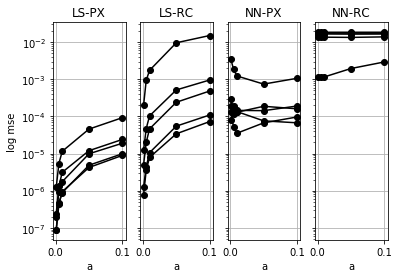

In [23]:
alpha = 0.5
data = mse_tot[(mse_tot["alpha"] == alpha)]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
plt.set_cmap("gray")
ax1.set_title("LS-PX")
ax2.set_title("LS-RC")
ax3.set_title("NN-PX")
ax4.set_title("NN-RC")

i = 1
for D in set(data["D"]):
    
    cond = data[(data["D"] ==  D) & (data["alpha"]==alpha)]
    
    
    cond          = cond.sort_values(by=["a"])
    cond["D"]     = np.around(cond["D"], 2)
    cond["a"]     = np.around(cond["a"], 3)
    cond["alpha"] = np.around(cond["alpha"], 1)

    x = cond["a"]
    
    ax1.semilogy(x, cond["D_ls_px"], '-o', c='k')
    ax1.grid()
    ax1.set_xlabel("a")
    
    ax2.semilogy(x, cond["D_ls_rc"], '-o', c='k')
    ax2.grid()
    ax2.set_xlabel("a")
    
    ax3.semilogy(x, cond["D_nn_px"], '-o', c='k')
    ax3.grid()
    ax3.set_xlabel("a")
    
    ax4.semilogy(x, cond["D_nn_rc"], '-o', c='k')
    ax4.grid()
    ax4.set_xlabel("a")
    
    cond.to_csv("D_data_"+"_"+str(alpha)+"_"+str(i)+".csv", index=False)
    
    i +=1
    
ax1.set_ylabel("log mse")    
plt.show()

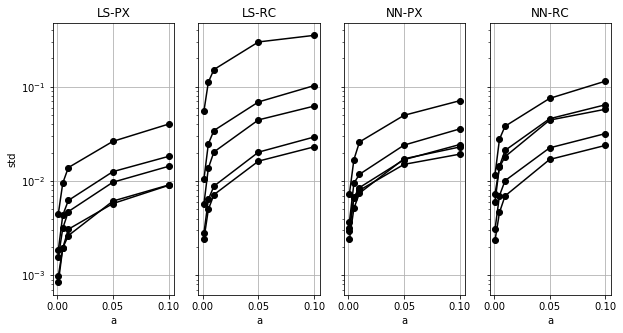

In [91]:
alpha = 0.9
data = std_tot[(std_tot["alpha"] == alpha)]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
plt.set_cmap("gray")
ax1.set_title("LS-PX")
ax2.set_title("LS-RC")
ax3.set_title("NN-PX")
ax4.set_title("NN-RC")

i = 1
for D in set(data["D"]):
    
    cond = data[(data["D"] ==  D) & (data["alpha"]==alpha)]
    
    
    cond          = cond.sort_values(by=["a"])
    cond["D"]     = np.around(cond["D"], 2)
    cond["a"]     = np.around(cond["a"], 3)
    cond["alpha"] = np.around(cond["alpha"], 1)

    x = cond["a"]
    
    ax1.semilogy(x, cond["D_ls_px"], '-o', c='k')
    ax1.grid()
    ax1.set_xlabel("a")
    
    ax2.semilogy(x, cond["D_ls_rc"], '-o', c='k')
    ax2.grid()
    ax2.set_xlabel("a")
    
    ax3.semilogy(x, cond["D_nn_px"], '-o', c='k')
    ax3.grid()
    ax3.set_xlabel("a")
    
    ax4.semilogy(x, cond["D_nn_rc"], '-o', c='k')
    ax4.grid()
    ax4.set_xlabel("a")
    
    cond.to_csv("std_D_data_"+"_"+str(alpha)+"_"+str(i)+".csv", index=False)
    
    i +=1
    
ax1.set_ylabel("std")    
plt.show()

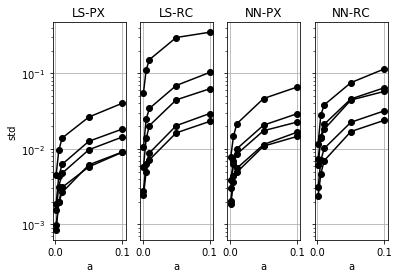

In [11]:
alpha = 0.9
data = std_tot[(std_tot["alpha"] == alpha)]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
plt.set_cmap("gray")
ax1.set_title("LS-PX")
ax2.set_title("LS-RC")
ax3.set_title("NN-PX")
ax4.set_title("NN-RC")

i = 1
for D in set(data["D"]):
    
    cond = data[(data["D"] ==  D) & (data["alpha"]==alpha)]
    
    
    cond          = cond.sort_values(by=["a"])
    cond["D"]     = np.around(cond["D"], 2)
    cond["a"]     = np.around(cond["a"], 3)
    cond["alpha"] = np.around(cond["alpha"], 1)

    x = cond["a"]
    
    ax1.semilogy(x, cond["D_ls_px"], '-o', c='k')
    ax1.grid()
    ax1.set_xlabel("a")
    
    ax2.semilogy(x, cond["D_ls_rc"], '-o', c='k')
    ax2.grid()
    ax2.set_xlabel("a")
    
    ax3.semilogy(x, cond["D_nn_px"], '-o', c='k')
    ax3.grid()
    ax3.set_xlabel("a")
    
    ax4.semilogy(x, cond["D_nn_rc"], '-o', c='k')
    ax4.grid()
    ax4.set_xlabel("a")
    
    cond.to_csv("std_D_data_"+"_"+str(alpha)+"_"+str(i)+".csv", index=False)
    
    i +=1
    
ax1.set_ylabel("std")    
plt.show()

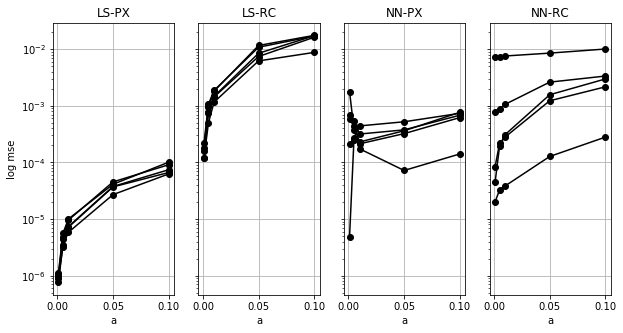

In [73]:
D = 2.9375715
data = mse_tot[(mse_tot["D"] == D)]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
plt.set_cmap("gray")
ax1.set_title("LS-PX")
ax2.set_title("LS-RC")
ax3.set_title("NN-PX")
ax4.set_title("NN-RC")

i = 1
for alpha in set(data["alpha"]):
    
    cond = data[(data["D"] ==  D) & (data["alpha"]==alpha)]
    
    
    cond          = cond.sort_values(by=["a"])
    cond["D"]     = np.around(cond["D"], 2)
    cond["a"]     = np.around(cond["a"], 3)
    cond["alpha"] = np.around(cond["alpha"], 1)

    x = cond["a"]
    
    ax1.semilogy(x, cond["alpha_ls_px"], '-o', c='k')
    ax1.grid()
    ax1.set_xlabel("a")
    
    ax2.semilogy(x, cond["alpha_ls_rc"], '-o', c='k')
    ax2.grid()
    ax2.set_xlabel("a")
    
    ax3.semilogy(x, cond["alpha_nn_px"], '-o', c='k')
    ax3.grid()
    ax3.set_xlabel("a")
    
    ax4.semilogy(x, cond["alpha_nn_rc"], '-o', c='k')
    ax4.grid()
    ax4.set_xlabel("a")
    
    cond.to_csv("alpha_data_"+"_"+str(2.94)+"_"+str(i)+".csv", index=False)
    
    i +=1
    
ax1.set_ylabel("log mse")    
plt.show()

In [36]:
r = np.random.randint(0, 100)
torch.manual_seed(r)
test_set = TemporalDataset(prefix = "rc", directory="/home/sms/vws/data/test/")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=16)

df = test(model_rc.cpu(), test_loader)

In [95]:
D_df = pd.concat([mse_tot[["D", "c0", "alpha", "a"]], 
                  avg_tot[["D_ls_px", "D_ls_rc", "D_nn_px", "D_nn_rc"]].rename(columns={"D_ls_px": "avg_ls_px", "D_ls_rc": "avg_ls_rc", "D_nn_px": "avg_nn_px", "D_nn_rc": "avg_nn_rc"}),
                  std_tot[["D_ls_px", "D_ls_rc", "D_nn_px", "D_nn_rc"]].rename(columns={"D_ls_px": "std_ls_px", "D_ls_rc": "std_ls_rc", "D_nn_px": "std_nn_px", "D_nn_rc": "std_nn_rc"}),
                  mse_tot[["D_ls_px", "D_ls_rc", "D_nn_px", "D_nn_rc"]].rename(columns={"D_ls_px": "mse_ls_px", "D_ls_rc": "mse_ls_rc", "D_nn_px": "mse_nn_px", "D_nn_rc": "mse_nn_rc"}),
                 ], axis=1)


In [119]:
test_set = SpatiotemporalDataset("/home/sms/vws/data/test/new")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=4)

df_test = test(model.cpu(), test_loader)

In [120]:
df_test.apply(np.sum)

loss         tensor(0.0004)
D            tensor(0.0009)
c0       tensor(3.6473e-05)
alpha        tensor(0.0002)
dtype: object

In [127]:
test_set = TemporalDataset(directory="/home/sms/vws/data/test/new", prefix="rc")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=4)

df_test = test(model_rc.cpu(), test_loader)

In [128]:
df_test.apply(np.sum)

loss         tensor(0.0074)
D            tensor(0.0213)
c0       tensor(8.9017e-06)
alpha        tensor(0.0009)
dtype: object